## Introduction
Employee turn-over costs a lot of money for companies, especially when people terminate before a full-year employment.
The dataset recorded the join and quit events of employees for a dozen of companies. The goal is to gain insights that what are the factors accociated with turn-over.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

In [2]:
retention_df = pd.read_csv('employee_retention_data.csv')

In [3]:
retention_df.dtypes


employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

In [4]:
retention_df.isnull().sum()


employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

In [5]:
retention_df.head(10)

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22
5,509529.0,4,data_science,14,165000.0,2012-01-30,2013-08-30
6,88600.0,4,customer_service,21,107000.0,2013-10-21,NaN
7,716309.0,2,customer_service,4,30000.0,2014-03-05,NaN
8,172999.0,9,engineer,7,160000.0,2012-12-10,2015-10-23
9,504159.0,1,sales,7,104000.0,2012-06-12,NaN


In [6]:
# change to categorical variable
retention_df['company_id'] = retention_df['company_id'].astype('category')

In [7]:
# create quit label 1 for yes 0 for no
retention_df['quit'] = retention_df['quit_date'].apply(lambda x: 1 if x is not np.nan else 0)
retention_df['join_date']= pd.to_datetime(retention_df['join_date'])
retention_df['quit_date']=pd.to_datetime(retention_df['quit_date'])

In [8]:
summary = pd.DataFrame(columns=['date','head_count','company_id'])
company_id = retention_df['company_id'].unique()
for i in company_id: 
    # get one company
    tmp = retention_df[retention_df['company_id']==i].copy()
    # get join event, groupby dates, count how many people hired
    j = tmp[['employee_id','join_date']].groupby('join_date',as_index=False).count()
    j.rename(columns={'join_date':'date','employee_id':'count'},inplace=True)
    
    # get quit event, note not every row has quit event
    tmp2 = tmp[tmp['quit']==1].copy()
    # group by dates, count how many people left
    q = tmp2[['employee_id','quit_date']].groupby('quit_date',as_index=False).count()
    # change the count to negative value
    q['count']=  q['employee_id'].apply(lambda x: 0-x)
    # rename column for concatenate two dataframe
    q.rename(columns={'quit_date':'date'},inplace=True)
    print "%d people were hired by company '%d',and %d people left." %(j['count'].sum(),i,q['employee_id'].sum())
    
    # concatenate join and quit
    jq = pd.concat([j,q],axis=0)
    # sort by date before concatenate
    jq.sort_values('date',inplace=True)
    # get the cumulative sum
    jq['head_count'] = jq['count'].cumsum()
    # add company id
    jq['company_id'] = i
    jq['company_id'] = jq['company_id'].astype('category')
    jq.drop(['count','employee_id'],axis=1,inplace=True)
    
    # append to summary dataframe
    summary = pd.concat([summary,jq],axis=0)
    del tmp,tmp2,j,q,jq
    

1224 people were hired by company '7',and 692 people left.
2062 people were hired by company '4',and 1153 people left.
4222 people were hired by company '2',and 2206 people left.
961 people were hired by company '9',and 529 people left.
8486 people were hired by company '1',and 4621 people left.
1291 people were hired by company '6',and 712 people left.
865 people were hired by company '10',and 480 people left.
1755 people were hired by company '5',and 983 people left.
2749 people were hired by company '3',and 1531 people left.
1047 people were hired by company '8',and 579 people left.
16 people were hired by company '11',and 12 people left.
24 people were hired by company '12',and 12 people left.


In [9]:
summary.sort_values('date',inplace=True)
summary['company_id'] = summary['company_id'].astype('category')

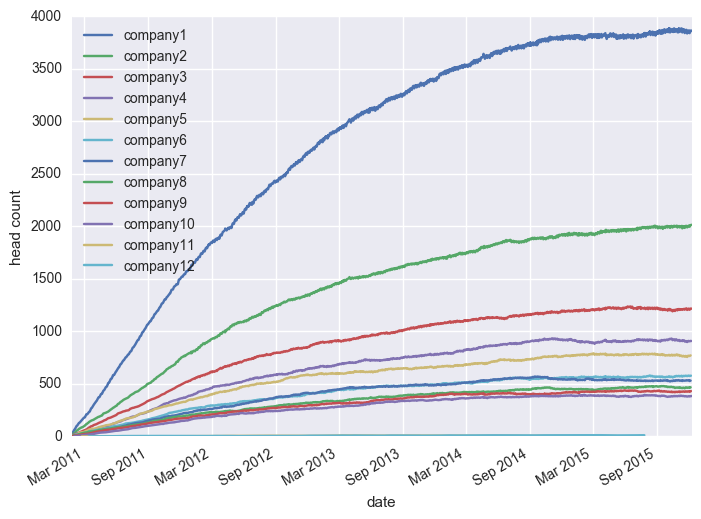

In [10]:
fig, ax = plt.subplots(figsize=(8,6))
for i,group in summary.groupby('company_id'):
    company_id = group['company_id'].unique()[0]
    group.plot.line(ax=ax,x='date', y='head_count',label='company'+str(company_id))
    ax.set_ylabel('head count')

* The graph above shows that the history of employment for each company

In [11]:
#create new column the week of the year
retention_df['quit_week'] = retention_df['quit_date'].dt.week
retention_df['quit_month']=retention_df['quit_date'].dt.month

In [12]:
# create new column the length of employment
last_date = pd.Timestamp(datetime(2015, 12, 13))
retention_df['length'] = (retention_df['quit_date'] - retention_df['join_date']).dt.days

In [13]:
retention_df['join_week'] = retention_df['join_date'].dt.week

### Visualization

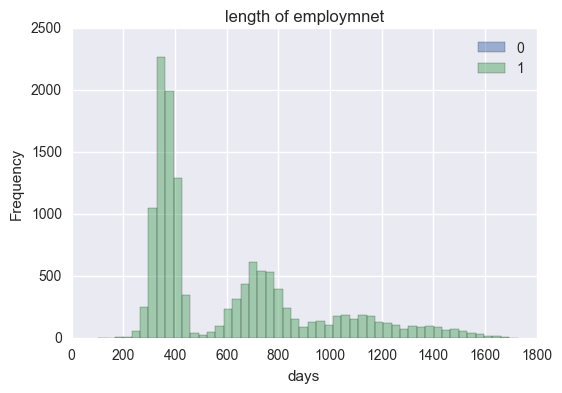

In [14]:
fig,ax = plt.subplots()
retention_df.groupby('quit')['length'].plot.hist(ax=ax, alpha=0.5,bins=50,legend=True)
ax.set_xlabel('days')
ax.set_title('length of employmnet')

(1, 53)

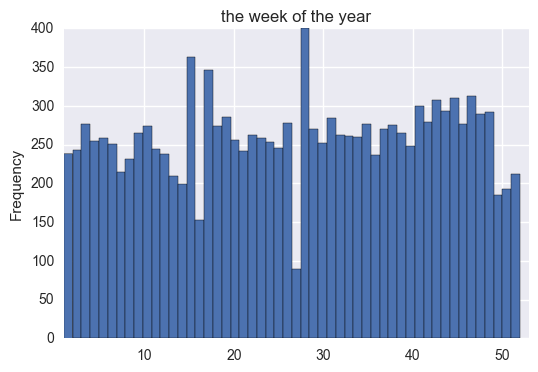

In [15]:
fig,ax = plt.subplots()
#sns.countplot('quit_week',data= retention_df)
#retention_df.groupby('quit_week').sum()[['employee_id']].plot.bar(ax=ax)
retention_df['quit_week'].plot.hist(bins=52)
ax.set_title('the week of the year')
ax.set_xlim([1,53])
#ax.locator_params(axis='x',nticks=10)

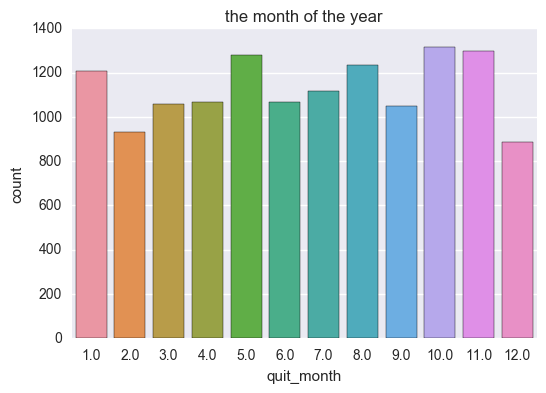

In [16]:
fig,ax = plt.subplots()
sns.countplot('quit_month',data= retention_df)
#retention_df.groupby('quit_week').sum()[['employee_id']].plot.bar(ax=ax)
#ax.set_xlabel('days')
ax.set_title('the month of the year')

In [17]:
# Add early_quit label
retention_df['early_quit'] = retention_df['length'].apply(lambda x: 1 if x<500 else 0)

In [18]:
retention_df['dept'] = retention_df['dept'].astype('category')

In [19]:
thresh = last_date - pd.Timedelta('365 days')
last_date = pd.Timestamp(datetime(2015, 12, 13))
early_quit = retention_df[retention_df['join_date']<thresh][['company_id','dept','seniority','salary','early_quit']].copy()

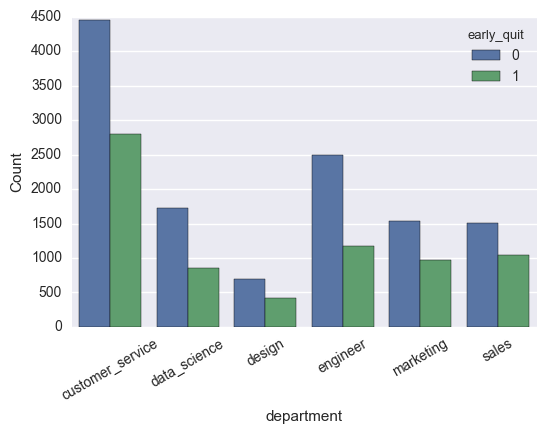

In [20]:
b =sns.countplot('dept',data=early_quit,hue='early_quit')
b.set_xticklabels(b.get_xticklabels(),rotation=30)
b.set_xlabel('department')
b.set_ylabel('Count')

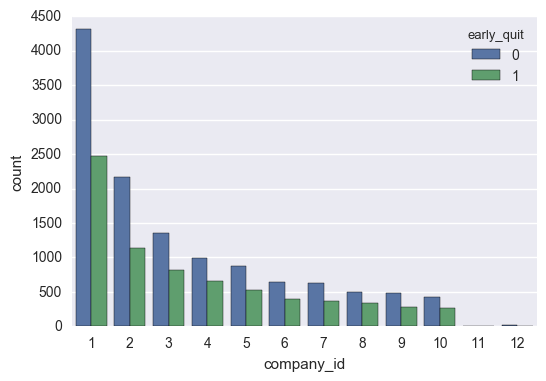

In [21]:
sns.countplot('company_id',data=early_quit,hue='early_quit')

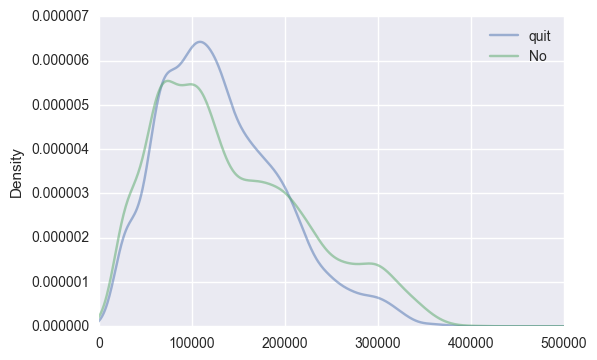

In [22]:
fig,ax=plt.subplots()
early_quit[early_quit['early_quit']==1].salary.plot.kde(ax=ax,alpha=0.5,label='quit')
early_quit[early_quit['early_quit']==0].salary.plot.kde(ax=ax,alpha=0.5,label='No')
ax.set_xlim([0,500000])
plt.legend()

### Employees with very high income and employees that do not make much money are less likely to quit.

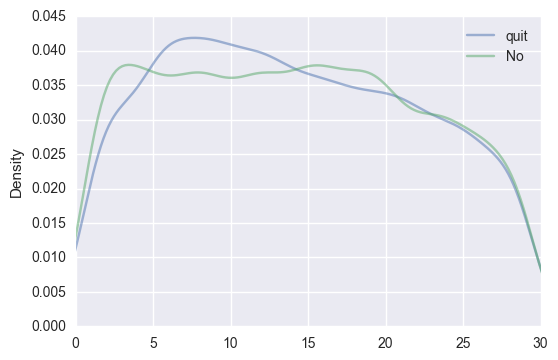

In [23]:
fig,ax=plt.subplots()
early_quit[early_quit['early_quit']==1].seniority.plot.kde(ax=ax,alpha=0.5,label='quit')
early_quit[early_quit['early_quit']==0].seniority.plot.kde(ax=ax,alpha=0.5,label='No')
ax.set_xlim([0,30])
plt.legend()

# Train a DecisionTree Model

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

In [25]:
Y = early_quit['early_quit']
X = pd.get_dummies(early_quit[[u'company_id', u'dept', u'seniority', u'salary']])

In [26]:
X[X['salary']>225000].count()[0]/float(X.shape[0])

0.14144753573063426

In [27]:
X_train,X_test,y_train, y_test = train_test_split(X,Y,test_size=0.33,random_state=42)

In [28]:
dt = DecisionTreeClassifier(max_depth=4)
tr_clf = dt.fit(X_train,y_train)

In [29]:
def get_code(tree, feature_names, tabdepth=0):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, tabdepth=0):
            if (threshold[node] != -2):
                    print '\t' * tabdepth,
                    print "if ( " + features[node] + " <= " + str(threshold[node]) + " ) {"
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node], tabdepth+1)
                    print '\t' * tabdepth,
                    print "} else {"
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node], tabdepth+1)
                    print '\t' * tabdepth,
                    print "}"
            else:
                    print '\t' * tabdepth,
                    print "return " + str(value[node])

    recurse(left, right, threshold, features, 0)

In [30]:
get_code(tr_clf,X.columns)

 if ( salary <= 225500.0 ) {
	if ( salary <= 89500.0 ) {
		if ( salary <= 54500.0 ) {
			if ( salary <= 21500.0 ) {
				return [[ 20.  19.]]
			} else {
				return [[ 933.  418.]]
			}
		} else {
			if ( salary <= 87500.0 ) {
				return [[ 1557.   912.]]
			} else {
				return [[ 99.  34.]]
			}
		}
	} else {
		if ( salary <= 181500.0 ) {
			if ( company_id_5 <= 0.5 ) {
				return [[ 2920.  2231.]]
			} else {
				return [[ 293.  161.]]
			}
		} else {
			if ( seniority <= 9.5 ) {
				return [[ 163.  130.]]
			} else {
				return [[ 891.  518.]]
			}
		}
	}
 } else {
	if ( salary <= 310500.0 ) {
		if ( company_id_9 <= 0.5 ) {
			if ( company_id_4 <= 0.5 ) {
				return [[ 992.  324.]]
			} else {
				return [[ 81.  45.]]
			}
		} else {
			if ( salary <= 249500.0 ) {
				return [[ 16.  19.]]
			} else {
				return [[ 15.   8.]]
			}
		}
	} else {
		if ( salary <= 339500.0 ) {
			if ( salary <= 338500.0 ) {
				return [[ 215.   43.]]
			} else {
				return [[ 1.  3.]]
			}
		} else {
			

### The most important feature is salary.